# Clustering of Trajectories under Global Confounding -- Chen-Poor

In [1]:
import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"
#optimal transport library
#import ot

#exotic clustering algorithm, TDA
#from tomaster import tomato
#from gudhi.clustering.tomato import Tomato


from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

#backtester
#import bt

#machine learning library for time series
#import tslearn
import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import ray
import datetime


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

%matplotlib inline
plt.style.use('matplotlibrc')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

In [2]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 200 #18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.6, small=True, soft=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [ ]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = confound_mdp.collect_sample(int(10000), mdp, pi_b, horizon, iid=False)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]
        

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

---
running env with horizon 200


In [4]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
@njit
def getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P):
    prob = np.zeros((nStates, nStates, nActions))
    for sp in range(nStates):
        for s in range(nStates):
            for a in range(nActions):
                for u in range(len(u_dist)):
                    prob[sp, s, a] += u_dist[u] * pi_b[u, s, a] * (1/pi_bsa[s,a]) * P[u, a, s, sp]
    return prob
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

N_sa = np.zeros((nStates, nActions))
for s,a,u,sp,r in data:
    N_sa[int(s),int(a)] += 1

In [5]:
burnin = 10
N_sa = np.zeros((nStates, nActions))
for s,a,u,sp,r in dataset[:, burnin:, :].reshape(dataset[:, burnin:, :].shape[0]*dataset[:, burnin:, :].shape[1], dataset[:, burnin:, :].shape[2]):
    N_sa[int(s),int(a)] += 1

## Method 1: PCA >%> ToMATo Clustering >%> t-SNE

In [6]:
# x, a, u, x', r
dataset.shape

(10000, 100, 5)

In [6]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

#from sklearn.decomposition import PCA
#pca = PCA(n_components=10, whiten=False).fit_transform(X)

In [7]:
#threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
concattrajs = dataset.reshape(dataset.shape[0]*dataset.shape[1], dataset.shape[2])
threes = np.array([concattrajs[i:i+3] for i in range(len(concattrajs)-2)])
print(threes.shape)
threes = dataset #comment for non-sanity check
print(threes.shape)
stateactions = (threes[:,:,0] + threes[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
states = (threes[:,:,0]).astype(int)
actions = (threes[:,:,1]).astype(int)
currstates = threes[:,:,[0,1]].astype(int)
confounders = threes[:,:,2].astype(int)
labels = confounders[:,0].astype(int)
nextstates = threes[:,:,3].astype(int)

L = 2
K = 2
#S = nStates*nActions
#N = len(threes)

(1999998, 3, 5)
(10000, 200, 5)


In [9]:
dataset.shape

(10000, 100, 5)

## Mixing Time Analysis

So now we have our dataset encoded in something isomorphic to state-action tuples, we can take a look at mixing times. On a 4x4 gridworld, 15, 31, 47 and 63 correspond to the goal state. Here's a plot of the distribution over state-action tuples over time.

<AxesSubplot:>

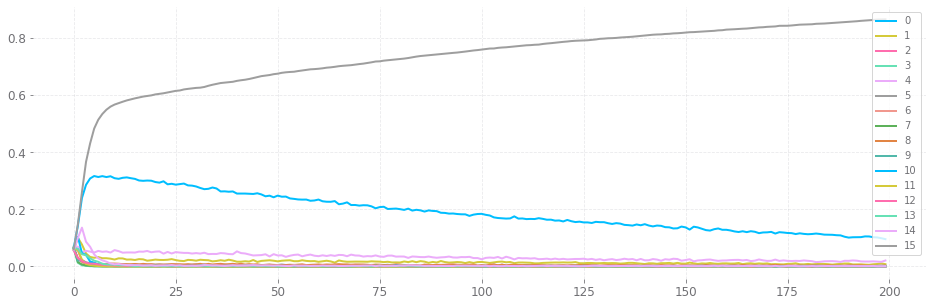

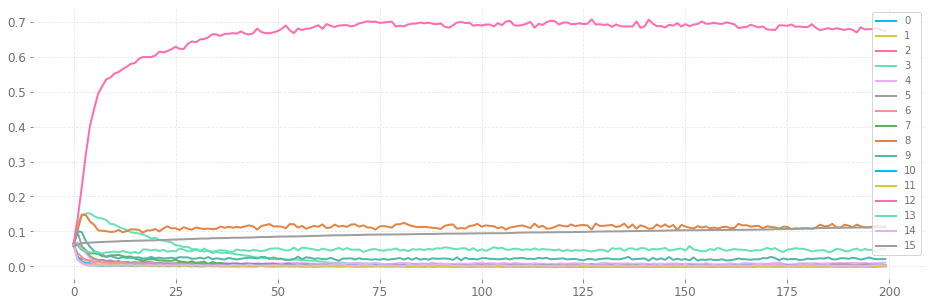

In [8]:
dist = np.array([np.bincount(states[:, i].astype(int)[labels==0], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==0)
pd.DataFrame(dist).plot(figsize=(16,5))
dist = np.array([np.bincount(states[:, i].astype(int)[labels==1], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==1)
pd.DataFrame(dist).plot(figsize=(16,5))

<AxesSubplot:>

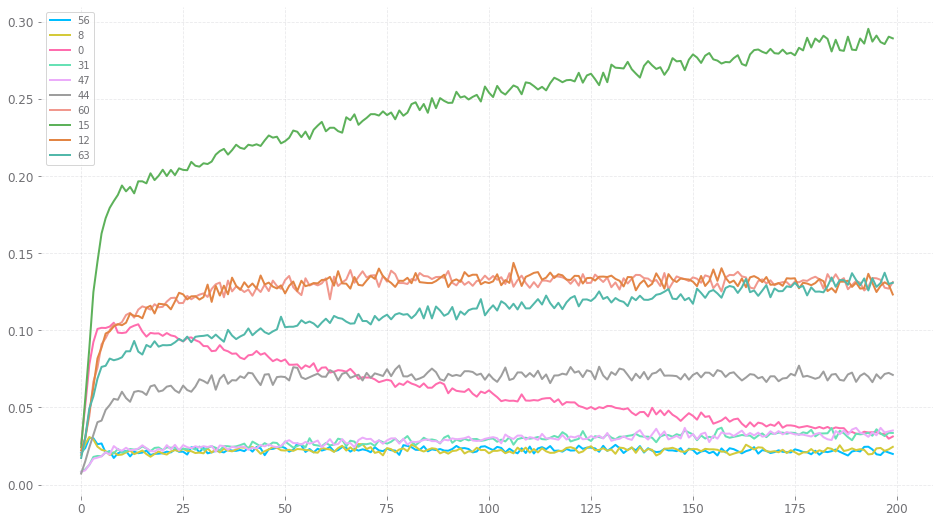

In [9]:
dist = np.array([np.bincount(stateactions[:, i].astype(int), minlength=nStates*nActions) 
         for i in range(stateactions.shape[1])])/len(labels)
pd.DataFrame(dist[:,np.argpartition(dist[-1,:], -10)[-10:]], 
            columns = np.argpartition(dist[-1,:], -10)[-10:]).plot(figsize=(16,9))
#pd.DataFrame(dist[:,[15,31,47,63]]/100000, 
#            columns = [15,31,47,63]).plot(figsize=(16,9))

And here's a plot of the L1-norm between distributions at step t and step t+1 over time. This converges really quickly to something in the neighborhood of 0.02. 

In [12]:
dist[:,:].shape

(100, 64)

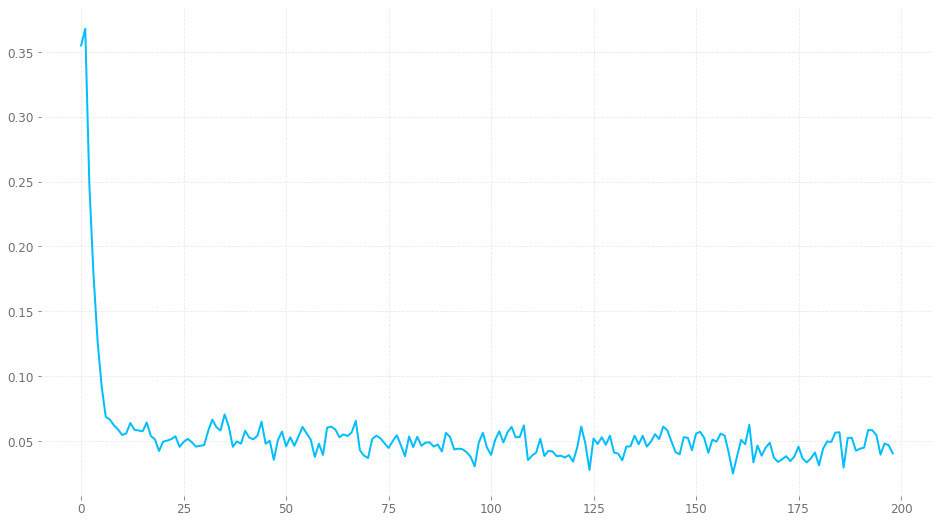

In [10]:
plt.figure(figsize=(16,9))
plt.plot(np.sum(np.abs(np.diff(dist, axis=0)),1))

## Subspace Estimation

In [812]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = np.eye(np.max(stateactions)+1)[stateactions]
onehotsaflat = copy.deepcopy(onehotsa)
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order='F')
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
sz = int(onehotsa.shape[0]/3)

In [813]:
onehotsasub = onehotsa[:sz]
onehotsaflatsub = onehotsaflat[:sz]
onehotspsub = onehotsp[:sz]

onehotsaclust = onehotsa[sz:2*sz]
onehotsaflatclust = onehotsaflat[sz:2*sz]
onehotspclust = onehotsp[sz:2*sz]

onehotsaclass = onehotsa[2*sz:]
onehotsaflatclass = onehotsaflat[2*sz:]
onehotspclass = onehotsp[2*sz:]

In [814]:
np.array([i for i in range(64)]).reshape(nStates, nActions, order='F')
#so it turns out the s + a|S| ordering corresponds to Fortran ordering

array([[ 0, 16, 32, 48],
       [ 1, 17, 33, 49],
       [ 2, 18, 34, 50],
       [ 3, 19, 35, 51],
       [ 4, 20, 36, 52],
       [ 5, 21, 37, 53],
       [ 6, 22, 38, 54],
       [ 7, 23, 39, 55],
       [ 8, 24, 40, 56],
       [ 9, 25, 41, 57],
       [10, 26, 42, 58],
       [11, 27, 43, 59],
       [12, 28, 44, 60],
       [13, 29, 45, 61],
       [14, 30, 46, 62],
       [15, 31, 47, 63]])

In [822]:
htest = geth(onehotsa, onehotsp, simple=True)
htest = htest * onehotsa.shape[1]

In [842]:
htest[0,0,0]/sum(htest[0,0,0])

array([0.9380531 , 0.03539823, 0.        , 0.        , 0.02654867,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [854]:
np.random.multinomial(200, pvals=htest[0,0,0]/sum(htest[0,0,0]), size=10000).mean(0)/200

array([0.938252 , 0.0355745, 0.       , 0.       , 0.0261735, 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ])

In [861]:
sasamples[0,0]

array([0.938052, 0.035331, 0.      , 0.      , 0.026617, 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      ])

In [866]:
P.mean(0).transpose(1,0,2)[0,0]

array([0.668, 0.04 , 0.   , 0.   , 0.292, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [858]:
sasamples = np.zeros((nStates, nActions, nStates))
for s in range(nStates):
    for a in range(nActions):
        if sum(htest[0,s,a]/sum(htest[0,s,a])) > 0:
            sasamples[s,a] = np.random.multinomial(200, pvals=htest[0,s,a]/sum(htest[0,s,a]), size=10000).mean(0)/200

In [674]:
from numba import prange
@njit(parallel=True)
def geth(onehotsa, onehotsp, simple=False):
    h = np.zeros((onehotsa.shape[0], onehotsa.shape[2], onehotsa.shape[3], onehotsa.shape[2])) #m, s, a, sp
    N_msa = np.zeros((onehotsa.shape[0], onehotsa.shape[2], onehotsa.shape[3]))
    for m in range(onehotsa.shape[0]):
        for s in range(onehotsa.shape[2]):
            for a in range(onehotsa.shape[3]):
                for sp in range(onehotsa.shape[2]):
                    for t in range(onehotsa.shape[1]):
                        h[m,s,a,sp] += onehotsa[m,t,s,a]*onehotsp[m,t,sp]
                        N_msa[m,s,a] += onehotsa[m,t,s,a]
    if not simple:
        for m in range(onehotsa.shape[0]):
            for s in range(onehotsa.shape[2]):
                for a in range(onehotsa.shape[3]):
                    for sp in range(onehotsa.shape[2]):
                        if N_msa[m,s,a] != 0:
                            h[m,s,a,sp] /= N_msa[m,s,a]
                        else:
                            h[m,s,a,sp] = 0
    else:
        h /= onehotsa.shape[1]
    return h

def getEig(onehotsa, onehotsp, omegaone, omegatwo, K):
    h1 = geth(onehotsa[:,omegaone,:,:], onehotsp[:,omegaone,:])
    h2 = geth(onehotsa[:,omegatwo,:,:], onehotsp[:,omegatwo,:])
    #Hsa = (h1 * h2).sum(3).mean(0)
    #Hsa = h1[:,:,:,:,None] * h2[:,:,:,None,:]
    #Hsa = np.einsum('ijkl,ijkm->ijklm', h1, h2).mean(0) #somehow einsum is faster? but equivalent
    Hsa = (h1[...,None] @ h2[...,None,:]).mean(0)
    Hht = Hsa + Hsa.transpose(0,1,3,2)
    eigvalsa, eigvecsa = np.linalg.eigh(Hht)
    return eigvalsa[:,:,-K:], eigvecsa[:,:,:,-K:]

eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K)

In [816]:
def getEigKs(onehotsa, onehotsp, omegaone, omegatwo, K):
    k1 = onehotsp[:,omegaone,:].mean(1)
    k2 = onehotsp[:,omegatwo,:].mean(1)
    Ks = (k1[...,None] @ k2[...,None,:]).mean(0)
    eigvalsp, eigvecsp = np.linalg.eigh(Ks + Ks.T)
    return eigvalsp[-K:], eigvecsp[:,-K:]
eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

def getEigKsa(onehotsa, onehotsp, omegaone, omegatwo, K):

In [769]:
np.sum(np.abs(np.array([[(h1[:, s, a, :].T @ h2[:, s, a, :]) for a in range(nActions)] for s in range(nStates)]) - 
              np.einsum('ijkl,ijkm->ijklm', h1, h2).sum(0)))

8.651933336434325e-17

In [771]:
np.sum(np.abs((h1[...,None] @ h2[...,None,:]).sum(0) - np.einsum('ijkl,ijkm->ijklm', h1, h2).sum(0)))

0.0

In [775]:
%timeit np.array([[(h1[:, s, a, :].T @ h2[:, s, a, :]) for a in range(nActions)] for s in range(nStates)])

14.6 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [776]:
%timeit np.einsum('ijkl,ijkm->ijklm', h1, h2).sum(0)

255 ms ± 8.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [777]:
%timeit (h1[...,None] @ h2[...,None,:]).sum(0)

317 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Finally, as a sanity check, we plot the absolute difference in eigenvalues on the log scale. We want this to always be nonzero, so if any entry is missing in the plot, then we'd be in trouble.

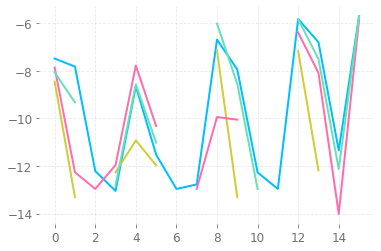

In [676]:
plt.plot(np.log(np.abs(eigvalsa[:,:,0] - eigvalsa[:,:,1])))

## Clustering

In [677]:
G = 4
omgones = np.array_split(omegaone,G)
omgtwos = np.array_split(omegatwo,G)
minlen = min([len(i) for i in omgones + omgtwos])
omgones = np.array([i[:minlen] for i in omgones])
omgtwos = np.array([i[:minlen] for i in omgtwos])

In [678]:
def geths(onehotsa, onehotsp, omgones, omgtwos, G=G):
    hs = []
    for g in tqdm(range(G)):
        hs.append([geth(onehotsa[:,omgones[g],:,:], onehotsp[:,omgones[g],:]), 
                   geth(onehotsa[:,omgtwos[g],:,:], onehotsp[:,omgtwos[g],:])])
    return np.array(hs)
hs = geths(onehotsaclust, onehotspclust, omgones, omgtwos)

100%|█████████████████████████████████████████████| 4/4 [00:01<00:00,  2.98it/s]


In [188]:
hs.shape

(4, 2, 3333, 16, 4, 16)

@njit(parallel=True, fastmath=True)
def getSims(onehotsaclust, hs, Vsa):
    M = onehotsaclust.shape[0]
    S = onehotsaclust.shape[2]
    A = onehotsaclust.shape[3]
    statmns = np.zeros((M,M))
    for m in prange(M):
        if m % 100 == 0:
            print(m)
        for n in range(M):
            if m < n:
                break
            statg = np.zeros(G)
            for g in range(G):
                maxstat = 0
                for s in range(S):
                    for a in range(A):
                        stat = ((hs[g,0,m,s,a] - hs[g,0,n,s,a]).T @ Vsa[s,a] 
                                 @ Vsa[s,a].T @ (hs[g,1,m,s,a] - hs[g,1,n,s,a]))
                        if stat > maxstat:
                            maxstat = stat
                statg[g] = maxstat
            statmns[m,n] = np.median(statg)
    return statmns + statmns.T - np.diag(np.diag(statmns))

statmns = getSims(onehotsaclust, hs, eigvecsa)

@njit(parallel=True, fastmath=True)
def getSims(onehotsaclust, h1, h2, Vsa):
    M = onehotsaclust.shape[0]
    S = onehotsaclust.shape[2]
    A = onehotsaclust.shape[3]
    statmns = np.zeros((M,M))
    for m in prange(M):
        if m % 100 == 0:
            print(m)
        for n in range(M):
            if m < n:
                break
            maxstat = 0
            for s in range(S):
                for a in range(A):
                    stat = ((h1[m,s,a] - h1[n,s,a]).T @ Vsa[s,a] 
                             @ Vsa[s,a].T @ (h2[m,s,a] - h2[n,s,a]))
                    if stat > maxstat:
                        maxstat = stat
            statmns[m,n] = maxstat
    return statmns + statmns.T - np.diag(np.diag(statmns))

statmns = getSims(onehotsaclust, 
                  geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:]),
                  geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:]), 
                  eigvecsa)

@njit(parallel=True, fastmath=True)
def getSims(onehotsaclust, proj1, proj2, Vsa):
    M = onehotsaclust.shape[0]
    S = onehotsaclust.shape[2]
    A = onehotsaclust.shape[3]
    statmns = np.zeros((M,M))
    for m in prange(M):
        if m % 100 == 0:
            print(m)
        for n in range(M):
            if m < n:
                break
            maxstat = 0
            for s in range(S):
                for a in range(A):
                    stat = ((proj1[m,s,a] - proj1[n,s,a]) @ (proj2[m,s,a] - proj2[n,s,a]))
                    if stat > maxstat:
                        maxstat = stat
            statmns[m,n] = maxstat
    return statmns + statmns.T - np.diag(np.diag(statmns))

statmns2 = getSims(onehotsaclust, 
                  proj1, proj2, 
                  eigvecsa)

proj1 = (geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:])[..., None,:] @ eigvecsa[None,...]).squeeze()
proj2 = (geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:])[..., None,:] @ eigvecsa[None,...]).squeeze()
statmns = ((proj1[None,...] - proj1[:,None,...]) * (proj2[None,...] - proj2[:,None,...])).sum(-1).max(axis=(2,3))

projs = (hs[..., None,:] @ eigvecsa[None,...]).squeeze()
statmns2 = np.median(((projs[:,0,None,...] - projs[:,0,:,None,...]) * 
            (projs[:,1,None,...] - projs[:,1,:,None,...])).sum(-1).max(axis=(3,4)), axis=0)
            
d_sa = (N_sa/N_sa.sum())

In [21]:
#((projs[:,0,None,...] - projs[:,0,:,None,...]) * 
#            (projs[:,1,None,...] - projs[:,1,:,None,...])).sum(-1).shape

In [22]:
#temp = ((projs[:,0,None,...] - projs[:,0,:,None,...]) * 
#            (projs[:,1,None,...] - projs[:,1,:,None,...])).sum(-1)

In [679]:
import tensorflow as tf
import tensorflow_probability as tfp

with tf.device("/GPU:0"):
    hst = tf.convert_to_tensor(hs, np.float64)
    eigvecsat = tf.convert_to_tensor(eigvecsa, np.float64)
    h1t = tf.convert_to_tensor(
                    geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:]), 
                np.float64)
    h2t = tf.convert_to_tensor(
                    geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:]),
                np.float64)
    d_sat = tf.convert_to_tensor(N_sa/N_sa.sum(), np.float64)
    
    proj1t = tf.squeeze(h1t[..., None,:] @ eigvecsat[None,...])
    proj2t = tf.squeeze(h2t[..., None,:] @ eigvecsat[None,...])
    statmns = tf.reduce_max(
                    tf.reduce_sum(
                        (proj1t[None,...] - proj1t[:,None,...]) * 
                        (proj2t[None,...] - proj2t[:,None,...]), 
                    axis=-1),
                axis=(2,3)).numpy()
    
    projst = tf.squeeze(hst[..., None,:] @ eigvecsat[None,...])
    statmns2 = tfp.stats.percentile(
                    tf.reduce_max(
                        tf.reduce_sum(
                            (projst[:,0,None,...] - projst[:,0,:,None,...]) * 
                            (projst[:,1,None,...] - projst[:,1,:,None,...]), 
                        axis=-1), 
                    axis=(3,4)), 
                axis=0, q=50.0, interpolation='midpoint').numpy()

In [648]:
(proj1t).shape

TensorShape([3333, 16, 4, 2])

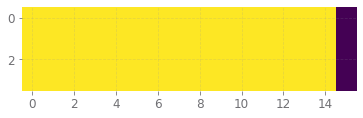

In [201]:
plt.imshow(np.linalg.norm((P[0].transpose(2,0,1) - P[1].transpose(2,0,1)), axis=0))

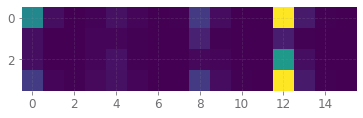

In [202]:
plt.imshow(np.linalg.norm((P[0].transpose(2,0,1) - P[1].transpose(2,0,1)) * d_sat.numpy().T[None,...], axis=0))

## weighted sum similarity code
temp = tf.reduce_sum(
        (projst[:,0,None,...] - projst[:,0,:,None,...]) * 
        (projst[:,1,None,...] - projst[:,1,:,None,...]), 
        axis=-1)

statmns3 = tfp.stats.percentile(
            tf.reduce_sum(temp * d_sat[None, None, None, ...], axis=(3,4)),
        axis=0, q=50.0, interpolation='midpoint').numpy()

statmns4 = tf.reduce_sum(
                    tf.reduce_sum(
                        (proj1t[None,...] - proj1t[:,None,...]) * 
                        (proj2t[None,...] - proj2t[:,None,...]), 
                    axis=-1) * d_sat[None, None, ...],
                axis=(2,3)).numpy()

import torch
device = torch.device("mps")
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns2.flatten(), bins=100, density=True)[2]
plt.hist(statmns2.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns2.flatten(), bw_adjust=0.5)
hsp = torch.tensor(hs.astype(np.float32), device=device)
eigvecsap = torch.tensor(eigvecsa.astype(np.float32), device=device)
h1p = torch.tensor(geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:]).astype(np.float32), device=device)
h2p = torch.tensor(geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:]).astype(np.float32), device=device)
d_sap = torch.tensor((N_sa/N_sa.sum()).astype(np.float32), device=device)
proj1p = torch.squeeze(h1p[..., None,:] @ eigvecsap[None,...])
proj2p = torch.squeeze(h2p[..., None,:] @ eigvecsap[None,...])
statmnsp = ((proj1p[None,...] - proj1p[:,None,...]) * (proj2p[None,...] - proj2p[:,None,...])).sum(-1).amax(axis=(2,3))
projsp = torch.squeeze(hsp[..., None,:] @ eigvecsap[None,...])
statmns2p = torch.median(((projsp[:,0,None,...] - projsp[:,0,:,None,...]) * 
            (projsp[:,1,None,...] - projsp[:,1,:,None,...])).sum(-1).max(axis=(3,4)), axis=0)


import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns4.flatten(), bins=100, density=True)[2]
plt.hist(statmns4.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns4.flatten(), bw_adjust=0.5)

import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns3.flatten(), bins=100, density=True)[2]
plt.hist(statmns3.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns3.flatten(), bw_adjust=0.5)

<AxesSubplot:ylabel='Density'>

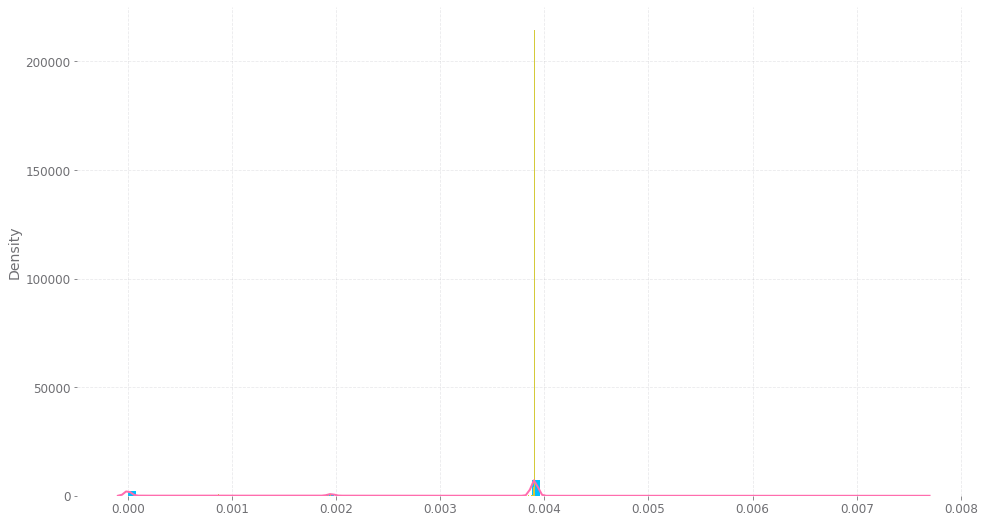

In [685]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns2.flatten(), bins=100, density=True)[2]
plt.hist(statmns2.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns2.flatten(), bw_adjust=0.5)

<AxesSubplot:ylabel='Density'>

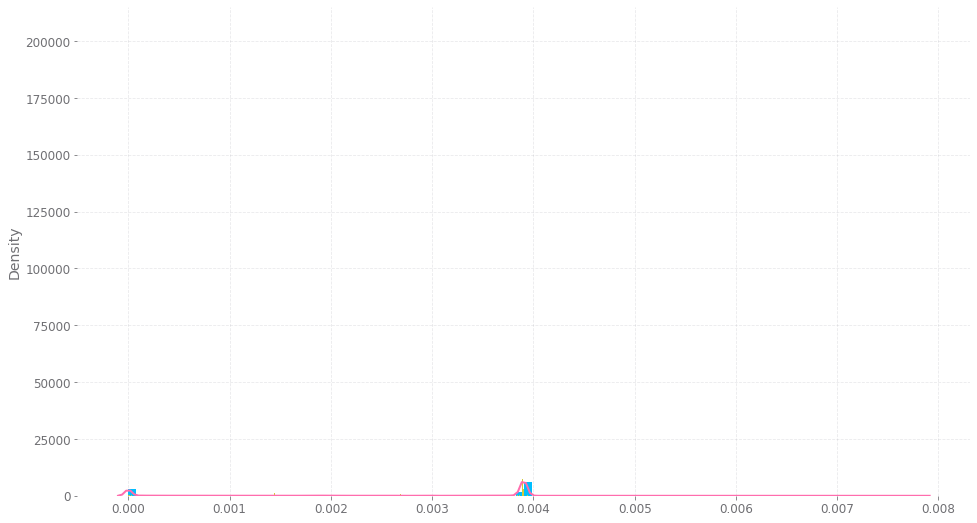

In [686]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=100, density=True)[2]
plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

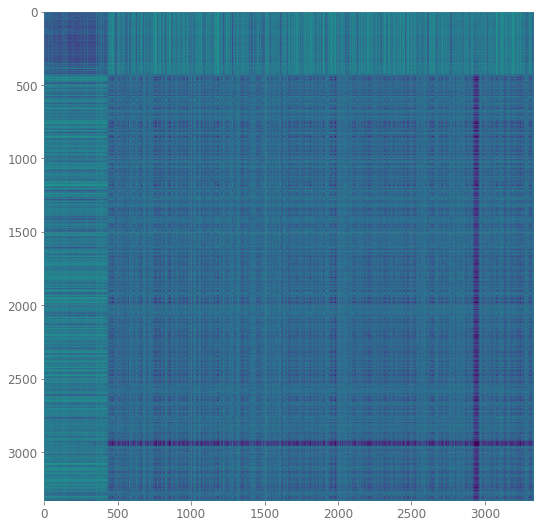

In [687]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns2 #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.64it/s]


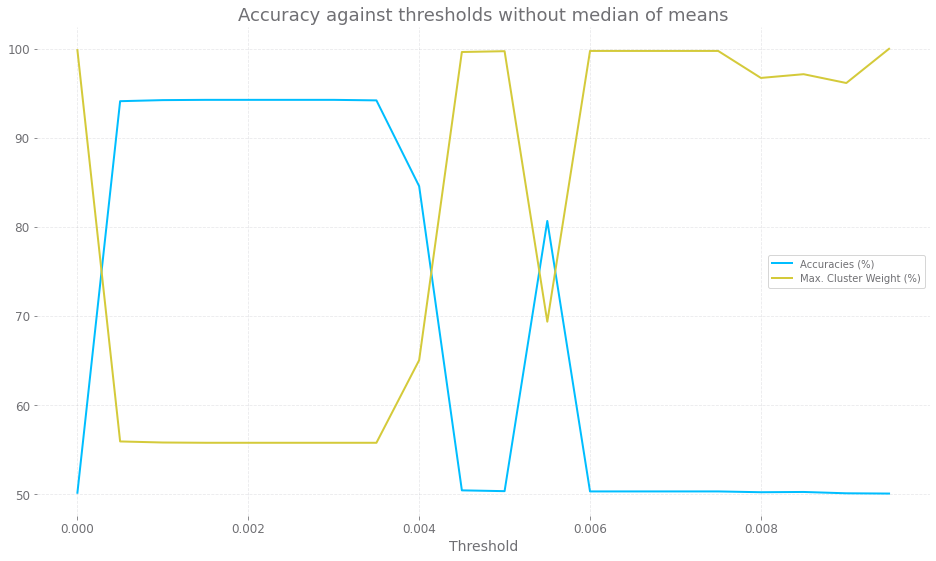

In [683]:
accs = []
wts = []
taus = np.arange(0, 0.01, 0.0005)
for tau in tqdm(taus):
    clusterlabs = sklearn.cluster.spectral_clustering((statmns < tau).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
    accs.append(max(np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])))
    wts.append(max(np.mean(clusterlabs==1), np.mean(clusterlabs==0)))
plt.figure(figsize=(16,9))
plt.plot(taus, 100*np.array(accs), label='Accuracies (%)')
plt.plot(taus, 100*np.array(wts), label='Max. Cluster Weight (%)')
plt.xlabel('Threshold')
plt.title('Accuracy against thresholds without median of means')
plt.legend()

100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


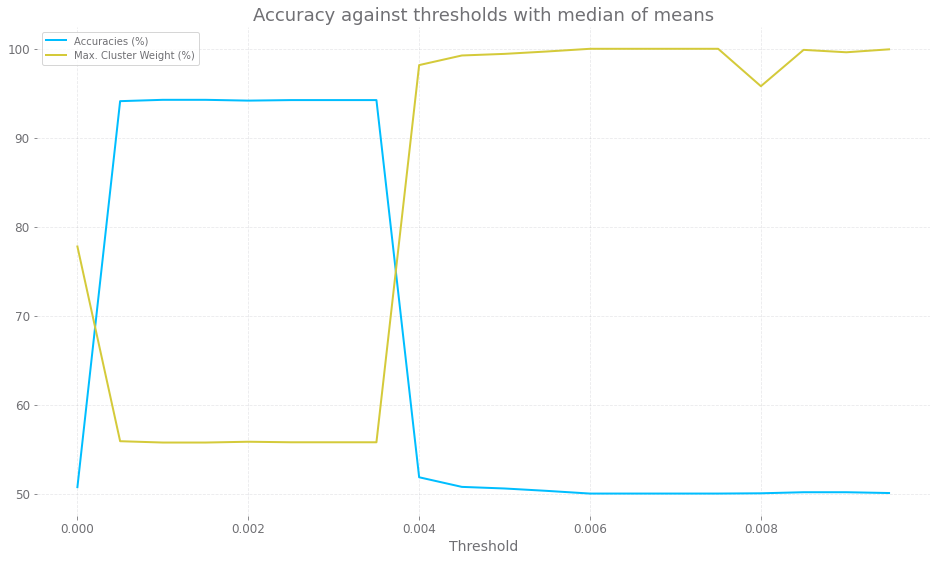

In [684]:
accs = []
wts = []
taus = np.arange(0, 0.01, 0.0005)
for tau in tqdm(taus):
    clusterlabs = sklearn.cluster.spectral_clustering((statmns2 < tau).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
    accs.append(max(np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])))
    wts.append(max(np.mean(clusterlabs==1), np.mean(clusterlabs==0)))
plt.figure(figsize=(16,9))
plt.plot(taus, 100*np.array(accs), label='Accuracies (%)')
plt.plot(taus, 100*np.array(wts), label='Max. Cluster Weight (%)')
plt.xlabel('Threshold')
plt.title('Accuracy against thresholds with median of means')
plt.legend()

100%|█████████████████████████████████████████| 105/105 [01:04<00:00,  1.64it/s]


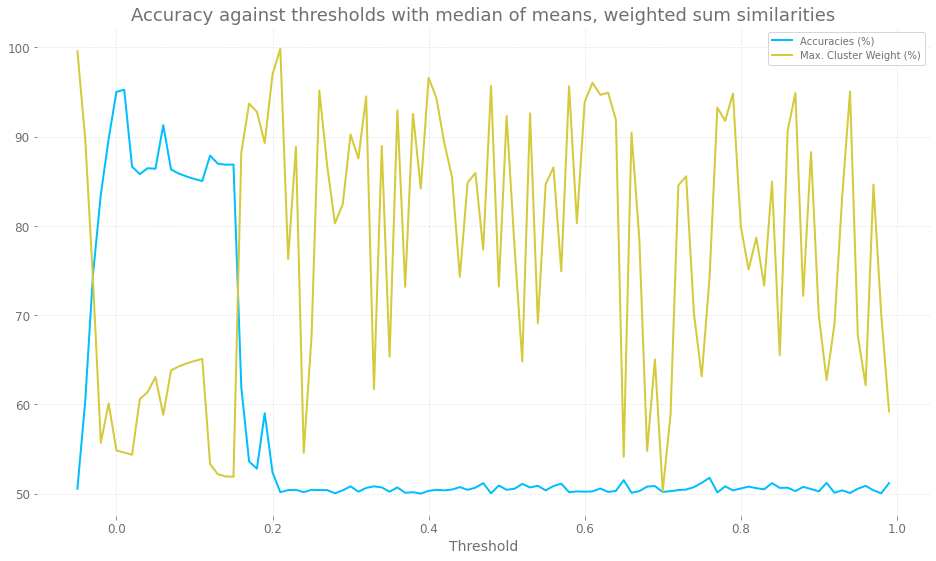

In [141]:
accs = []
wts = []
taus = np.arange(-0.05, 1, 0.01)
for tau in tqdm(taus):
    clusterlabs = sklearn.cluster.spectral_clustering((statmns3 < tau).astype(int), n_clusters=K,
                                                     assign_labels='cluster_qr')
    accs.append(max(np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])))
    wts.append(max(np.mean(clusterlabs==1), np.mean(clusterlabs==0)))
plt.figure(figsize=(16,9))
plt.plot(taus, 100*np.array(accs), label='Accuracies (%)')
plt.plot(taus, 100*np.array(wts), label='Max. Cluster Weight (%)')
plt.xlabel('Threshold')
plt.title('Accuracy against thresholds with median of means, weighted sum similarities')
plt.legend()

100%|█████████████████████████████████████████| 105/105 [01:02<00:00,  1.67it/s]


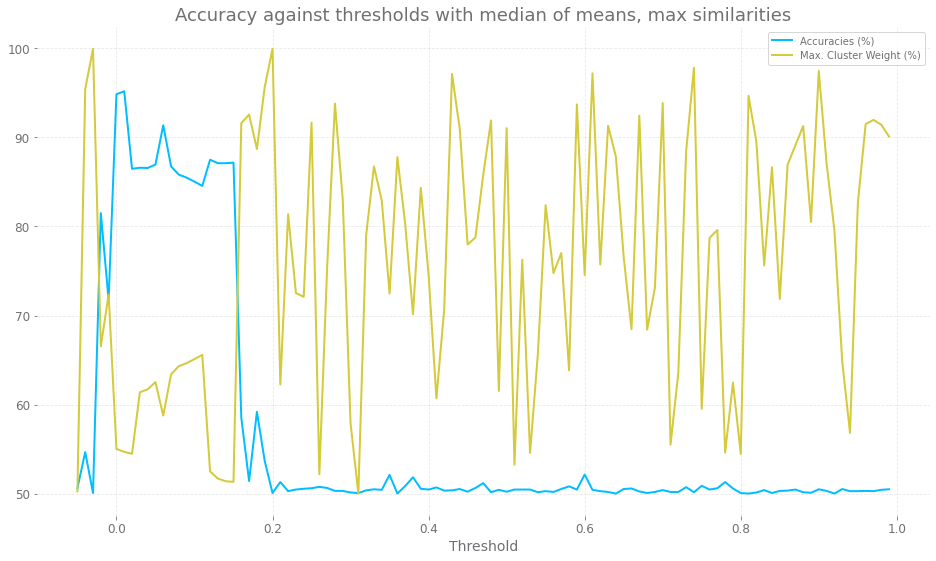

In [142]:
accs = []
wts = []
taus = np.arange(-0.05, 1, 0.01)
for tau in tqdm(taus):
    clusterlabs = sklearn.cluster.spectral_clustering((statmns4 < tau).astype(int), n_clusters=K,
                                                     assign_labels='cluster_qr')
    accs.append(max(np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])))
    wts.append(max(np.mean(clusterlabs==1), np.mean(clusterlabs==0)))
plt.figure(figsize=(16,9))
plt.plot(taus, 100*np.array(accs), label='Accuracies (%)')
plt.plot(taus, 100*np.array(wts), label='Max. Cluster Weight (%)')
plt.xlabel('Threshold')
plt.title('Accuracy against thresholds with median of means, max similarities')
plt.legend()

In [531]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, metric='precomputed').fit_transform(statmns) #1-(statmns2 < 0.002)

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

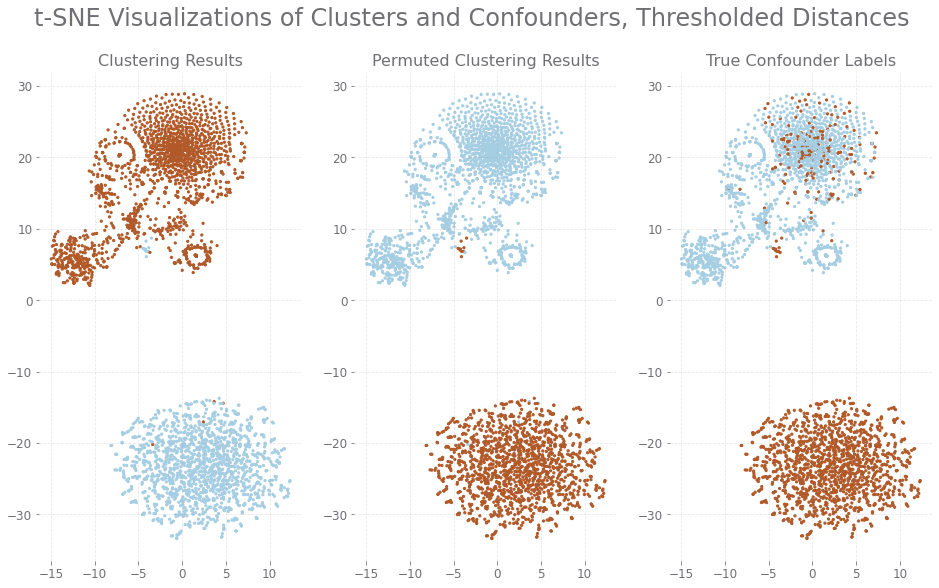

In [652]:
clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.002).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [362]:
permutation = np.argmax([np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])])
print(permutation, np.max([np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])]))

1 0.9423942394239424


(array([1475.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1858.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

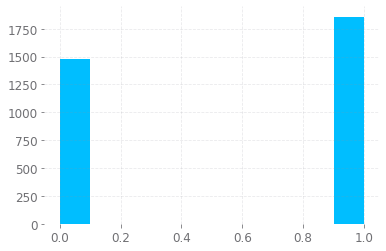

In [363]:
plt.hist(clusterlabs)

## Model Estimation

In [258]:
burnin = 10

In [653]:
@njit(parallel=False, fastmath=True)
def getmodelestim(clusterlabs, states, actions, nextstates,
                  K=K, nStates=nStates, nActions=nActions):
    Phat_ksa = np.zeros((K, nStates, nActions, nStates))
    for i in prange(states.shape[0]):
        for j in range(states.shape[1]):
            Phat_ksa[int(clusterlabs[i]), 
                     int(states[i,j]), 
                     int(actions[i,j]), 
                     int(nextstates[i,j])] += 1
    return Phat_ksa

@njit(parallel=False, fastmath=True)
def getmodelestimsoft(expect, states, actions, nextstates,
                  K=K, nStates=nStates, nActions=nActions):
    Phat_ksa = np.zeros((K, nStates, nActions, nStates))
    for i in prange(states.shape[0]):
        for j in range(states.shape[1]):
            for k in range(K):
                Phat_ksa[k, 
                         int(states[i,j]), 
                         int(actions[i,j]), 
                         int(nextstates[i,j])] += expect[k,i]
    return Phat_ksa

Phat_ksa = getmodelestim(clusterlabs.astype(int), states[sz:2*sz, burnin:], actions[sz:2*sz, burnin:], nextstates[sz:2*sz, burnin:])
Phat_ksa /= Phat_ksa.sum(-1)[..., None]

## Classification

In [377]:
np.bincount(clusterlabs)/len(clusterlabs) 

array([0.44254425, 0.55745575])

In [658]:
#denoised model estimate
Phat_ksad = np.array([eigvecsa @ eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()
#projected models
projPhat = np.array([eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()

lam = 1
priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
#priorclass = np.array([0.5,0.5])
mleprobs = (np.log(Phat_ksa[:, states[2*sz:, burnin:], actions[2*sz:, burnin:], nextstates[2*sz:, burnin:]]).sum(-1))
mleprobs += np.random.uniform(high=1e-7, size=mleprobs.shape)
maxapos = (mleprobs + lam*np.log(priorclass)[:,None]).argmax(0)
mle = mleprobs.argmax(0)

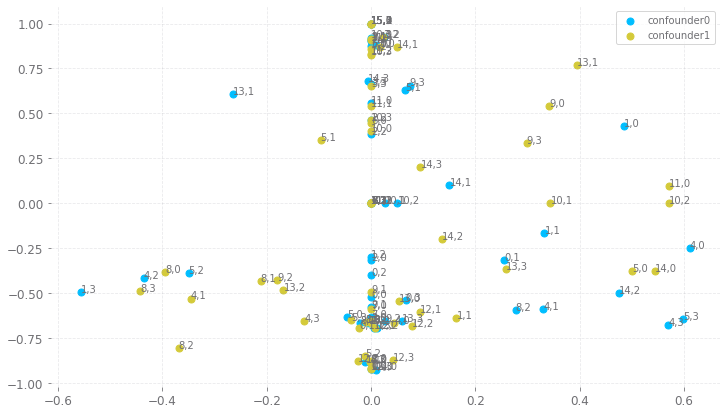

In [603]:
plt.figure(figsize=(12,7))
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[0,:,0], projPhat.reshape(K, nStates*nActions, K)[0,:,1], label='confounder0')
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[1,:,0], projPhat.reshape(K, nStates*nActions, K)[1,:,1], label='confounder1')
for s in range(nStates):
    for a in range(nActions):
        for k in range(K):
            plt.text(projPhat[k,s,a,0], projPhat[k,s,a,1], s=(str(s)+','+str(a)))
plt.legend()

In [660]:
projPhat.reshape(K, nStates*nActions, K).shape

(2, 64, 2)

In [659]:
np.mean(labels[2*sz:] == maxapos)
print('MAP estimate accuracy:', [np.mean(labels[2*sz:] == maxapos), np.mean(labels[2*sz:] != maxapos)][permutation])
print('MLE accuracy:', [np.mean(labels[2*sz:] == mle), np.mean(labels[2*sz:] != mle)][permutation])

MAP estimate accuracy: 0.9526094781043791
MLE accuracy: 0.8416316736652669


In [449]:
def getloglik(expect, modelestim, states, actions, nextstates, hard=True):
    if hard:
        return np.nansum(
                    np.nansum(
                        np.log(modelestim[:, states, actions, nextstates]), 
                    axis=-1)[expect, np.arange(len(states))])
    else:
        return np.nansum(
                    np.nansum(
                        np.log(np.nansum(modelestim[:, states, actions, nextstates] 
                                        * expect[...,None], axis=0)),
                    axis=-1))

def em(expect, modelestim, states, actions, nextstates, labels, 
               max_iter = 100, checkin=5, 
               reg = 0, prior = priorclass, 
               permute=False, permutation=permutation, verbose=True):
    i = 0
    modelold = np.ones(modelestim.shape)
    while i == 0 or np.nansum(np.abs(modelold - modelestim)) > 1e-3:
        modelold = modelestim
        modelestim = getmodelestim(expect.astype(int), states, actions, nextstates)
        modelestim /= modelestim.sum(-1)[..., None]
        expectprobs = np.log(modelestim[:, states, actions, nextstates]).sum(-1)
        expectprobs += np.random.uniform(high=1e-7, size=expectprobs.shape)
        expect = (expectprobs + #random number to perturb argmax 
                  reg*np.log(prior)[:,None]).argmax(0)
        i += 1
        if i % checkin == 0 and verbose:
            print('iteration', i, 'diff', np.nansum(np.abs(modelold - modelestim)))
            if permute:
                print('MLE accuracy:', max(np.mean(expect == labels), np.mean(expect != labels)))
            else:
                print('MLE accuracy:', [np.mean(expect == labels), np.mean(expect != labels)][permutation])
            print(getloglik(expect, modelestim, states, actions, nextstates, hard=True))
        if i > max_iter:
            break
    loglik = getloglik(expect, modelestim, states, actions, nextstates, hard=True)
    if verbose:
        print('log-likelihood:', loglik)
    return expect, modelestim, loglik

expectclass, modelestimclass, loglikclass = em(mle, Phat_ksa, states[2*sz:, burnin:], actions[2*sz:, burnin:], 
                        nextstates[2*sz:, burnin:], labels[2*sz:], 
                        reg = 0, prior = priorclass, permute=True, checkin=1)

iteration 1 diff 16.58984813746181
MLE accuracy: 0.8443311337732453
-198073.4277706283
iteration 2 diff 1.383422516209598
MLE accuracy: 0.8392321535692862
-198062.15238940303
iteration 3 diff 0.0
MLE accuracy: 0.8365326934613078
-198062.15238940303
log-likelihood: -198062.15238940303


In [216]:
(np.exp(mleprobs)/K).sum(0)

array([1.00000000e+00, 2.34306396e-34, 2.13998676e-40, ...,
       1.00000000e+00, 1.00000000e+00, 5.06468602e-40])

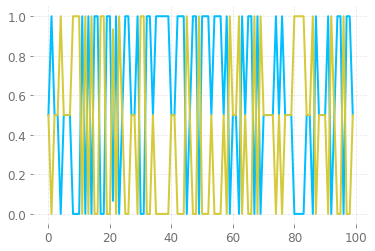

In [450]:
plt.plot((np.exp(mleprobs)/np.exp(mleprobs).sum(0))[:,-100:].T)

In [453]:
def emsoft(expect, modelestim, states, actions, nextstates, labels, 
               max_iter = 100, checkin=5, 
               reg = 0, prior = priorclass, 
               permute=False, permutation=permutation, verbose=True):
    i = 0
    modelold = np.ones(modelestim.shape)
    while i == 0 or np.nansum(np.abs(modelold - modelestim)) > 1e-3:
        modelold = modelestim
        modelestim = getmodelestimsoft(expect, states, actions, nextstates)
        modelestim /= np.nansum(modelestim, axis=-1)[..., None]
        expectprobs = np.nansum(np.log(modelestim[:, states, actions, nextstates]), axis=-1)
        expectprobs += np.random.uniform(high=1e-7, size=expectprobs.shape)
        expect = np.exp(expectprobs + 
                        reg*np.log(prior)[:,None])
        expect = (expect / np.nansum(np.abs(expect), axis=0))
        i += 1
        if i % checkin == 0 and verbose:
            print('iteration', i, 'diff', np.nansum(np.abs(modelold - modelestim)))
            if permute:
                print('MLE accuracy:', max(np.mean(np.argmax(expect,0) == labels), 
                                           np.mean(np.argmax(expect,0) != labels)))
            else:
                print('MLE accuracy:', [np.mean(np.argmax(expect,0) == labels), 
                                        np.mean(np.argmax(expect,0) != labels)][permutation])
            print(getloglik(expect, modelestim, states, actions, nextstates, hard=False))
        if i > max_iter:
            break
    loglik = getloglik(expect, modelestim, states, actions, nextstates, hard=False)
    if verbose:
        print('log-likelihood:', loglik)
    return expect, modelestim, loglik

expectclasssoft, modelestimclasssoft, loglikclasssoft = emsoft((np.exp(mleprobs)/np.exp(mleprobs).sum(0)), 
    Phat_ksa, states[2*sz:, burnin:], actions[2*sz:, burnin:], 
                        nextstates[2*sz:, burnin:], labels[2*sz:], 
                        reg = 0, prior = priorclass, permute=True, checkin=1)

iteration 1 diff 40.54691394160741
MLE accuracy: 0.8284343131373725
-inf
iteration 2 diff 29.39407648301689
MLE accuracy: 0.8407318536292742
-198059.71542337368
iteration 3 diff 1.881934533518351
MLE accuracy: 0.8386322735452909
-198047.0969068464
iteration 4 diff 0.16029490913505937
MLE accuracy: 0.8386322735452909
-198046.79979846207
iteration 5 diff 0.021544555447661234
MLE accuracy: 0.8278344331133773
-198046.78841299907
iteration 6 diff 0.004688379721225091
MLE accuracy: 0.8344331133773245
-198046.7908165648
iteration 7 diff 0.0015434308751476594
MLE accuracy: 0.8308338332333534
-198046.79178068967
iteration 8 diff 0.0006567894726742342
MLE accuracy: 0.8377324535092981
-198046.79184213735
log-likelihood: -198046.79184213735


## Refinement

In [454]:
catlabelsmap = np.concatenate([clusterlabs, maxapos]).astype(int)
catlabelsmle = np.concatenate([clusterlabs, mle]).astype(int)
catlabelsem = np.concatenate([clusterlabs, expectclass]).astype(int)
refinemap = getmodelestim(catlabelsmap, 
                       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
refinemap /= refinemap.sum(-1)[..., None]
refinemle = getmodelestim(catlabelsmle, 
                       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
refinemle /= refinemle.sum(-1)[..., None]
refineem = getmodelestim(catlabelsem, 
                       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
refineem /= refineem.sum(-1)[..., None]

In [455]:
refinemleprobs = np.log(refinemle[:, states[sz:, burnin:], 
                                  actions[sz:, burnin:], 
                                  nextstates[sz:, burnin:]]).sum(-1) 
refinemleprobs += np.random.uniform(high=1e-7, size=refinemleprobs.shape)
refinemaplab = (refinemleprobs + 
                  lam*np.log(np.bincount(catlabelsmap)/len(catlabelsmap))[:,None]).argmax(0)
refinemlelab = (refinemleprobs).argmax(0)
refineemlab = (np.log(refineem[:, states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:]]).sum(-1)).argmax(0)

In [456]:
print('MAP estimate accuracy:', [np.mean(refinemaplab == labels[sz:]), np.mean(refinemaplab != labels[sz:])][permutation])
print('MLE accuracy:', [np.mean(refinemlelab == labels[sz:]), np.mean(refinemlelab != labels[sz:])][permutation])

MAP estimate accuracy: 0.9529023548822559
MLE accuracy: 0.8341082945852707


In [457]:
print('Hard EM Algorithm') 
expect, modelestim, loglikrefine = em(refineemlab, refineem, states[sz:, burnin:], 
                                      actions[sz:, burnin:], nextstates[sz:, burnin:], labels[sz:], reg=0, checkin=1)

Hard EM Algorithm
iteration 1 diff 4.008585020165028
MLE accuracy: 0.8333583320833958
-389579.15333257744
iteration 2 diff 0.652772186893321
MLE accuracy: 0.8303584820758962
-389573.1858778706
iteration 3 diff 0.13302207623660608
MLE accuracy: 0.8287085645717714
-389572.8000158435
iteration 4 diff 0.0
MLE accuracy: 0.8354582270886456
-389572.8000158435
log-likelihood: -389572.8000158435


In [467]:
print('Soft EM Algorithm')
expect, modelestim, loglikrefine = emsoft(np.exp(refinemleprobs)/np.exp(refinemleprobs).sum(0), refineem, states[sz:, burnin:], 
                                      actions[sz:, burnin:], nextstates[sz:, burnin:], labels[sz:], 
                                          reg=0.1, checkin=1)

Soft EM Algorithm
iteration 1 diff 4.003821773658595
MLE accuracy: 0.9530523473826309
-389526.4896458127
iteration 2 diff 0.8583762958927906
MLE accuracy: 0.9533523323833808
-389521.263342049
iteration 3 diff 0.1676870848637912
MLE accuracy: 0.9533523323833808
-389521.05252372444
iteration 4 diff 0.04262694315498056
MLE accuracy: 0.9533523323833808
-389520.9992566959
iteration 5 diff 0.014508076712229943
MLE accuracy: 0.9533523323833808
-389520.9669524007
iteration 6 diff 0.006481031097779996
MLE accuracy: 0.9533523323833808
-389520.9478155237
iteration 7 diff 0.0034248305776393498
MLE accuracy: 0.9533523323833808
-389520.93662799103
iteration 8 diff 0.00194952689108761
MLE accuracy: 0.9533523323833808
-389520.93006811605
iteration 9 diff 0.0011454465607637718
MLE accuracy: 0.9533523323833808
-389520.9261985846
iteration 10 diff 0.0006791458682867367
MLE accuracy: 0.9533523323833808
-389520.92390550184
log-likelihood: -389520.92390550184


## Stable Baselines: EM Algorithm Alone

In [459]:
randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
randmodel = getmodelestim(randlabs, states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:])
randlabs, randmodel, loglikrand = em(randlabs, randmodel,
   states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:], labels, reg=0, permute=True, checkin=5)

iteration 5 diff 6.933752788304653
MLE accuracy: 0.8304
-584992.5809755342
log-likelihood: -584979.2935251949


In [460]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getmodelestimsoft(randlabsoft, states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:])
randlabs, randmodel, loglikrand = emsoft(randlabsoft, randmodelsoft,
   states[:, burnin:], actions[:, burnin:], nextstates[:, burnin:], labels, reg=0, permute=True, checkin=5, verbose=True)

iteration 5 diff 16.94393153503216
MLE accuracy: 0.8241
-587449.4722506444
iteration 10 diff 1.0142257923880242
MLE accuracy: 0.8362
-583445.9972278257
iteration 15 diff 0.14517186037707727
MLE accuracy: 0.8309
-583443.3447873468
iteration 20 diff 0.042452185812573914
MLE accuracy: 0.8374
-583442.146303008
iteration 25 diff 0.19937974525719343
MLE accuracy: 0.8398
-583444.0625316993
iteration 30 diff 0.0006518494337638943
MLE accuracy: 0.8348
-583444.4504165177
log-likelihood: -583444.4504165177


In [474]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset[sz:]))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getmodelestimsoft(randlabsoft, states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
    randlabsoft, randmodelsoft, loglikrand = emsoft(randlabsoft, randmodelsoft,
       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:], labels, reg=1e-5, permute=True, checkin=5, verbose=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:46<00:00,  1.53s/it]


In [475]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset[sz:])).astype(int)
    randmodel = getmodelestim(randlabs, states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:])
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states[sz:, burnin:], actions[sz:, burnin:], nextstates[sz:, burnin:], labels, reg=1e-5, permute=True, verbose=False)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:15<00:00,  1.91it/s]


In [106]:
np.array([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem])[np.argpartition(logliksem, 50)[-50:]].mean()

0.8188480575971201

Text(0.5, 1.0, 'Randomly Initialized Hard EM Algorithm')

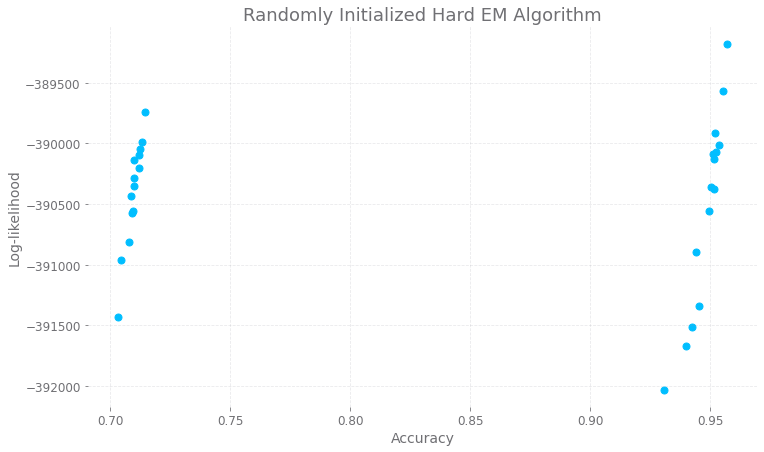

In [476]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem], logliksem)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')

Text(0.5, 1.0, 'Randomly Initialized Soft EM Algorithm')

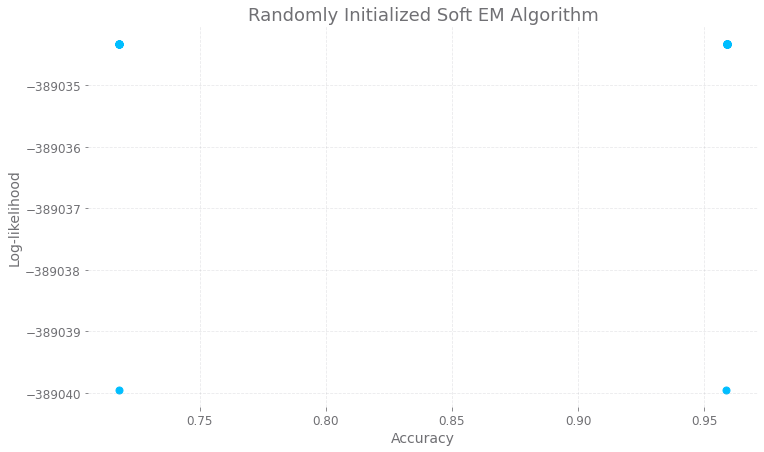

In [477]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')

(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.]),
 array([0.71771411, 0.74186291, 0.7660117 , 0.79016049, 0.81430928,
        0.83845808, 0.86260687, 0.88675566, 0.91090445, 0.93505325,
        0.95920204]),
 <BarContainer object of 10 artists>)

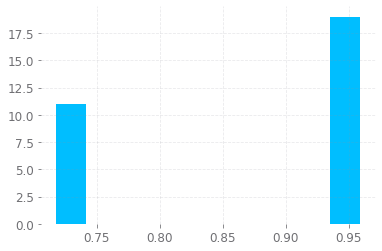

In [478]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in np.array(labelsemsoft).argmax(axis=1)])

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 14.]),
 array([0.70181491, 0.72732863, 0.75284236, 0.77835608, 0.80386981,
        0.82938353, 0.85489726, 0.88041098, 0.9059247 , 0.93143843,
        0.95695215]),
 <BarContainer object of 10 artists>)

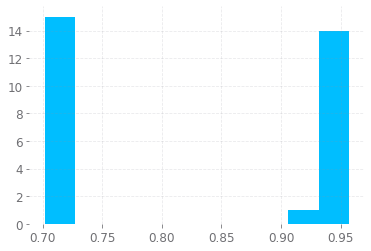

In [479]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem])

## Stable Baselines: Occupancy Counts Past Mixing Time

In [481]:
onehots = onehotsaclust[:, omegatwo,...].sum(1)
statbase = np.abs(onehots[None,...] - onehots[:,None,...]).sum(axis=(2,3))
tsnebase = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                                 metric='precomputed').fit_transform(statbase)
clusterlabs = sklearn.cluster.spectral_clustering((statbase.max() - statbase), n_clusters=K,
                                                     assign_labels='kmeans')
max(np.mean(clusterlabs == labels[sz:2*sz]), np.mean(clusterlabs != labels[sz:2*sz]))

0.876987698769877

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

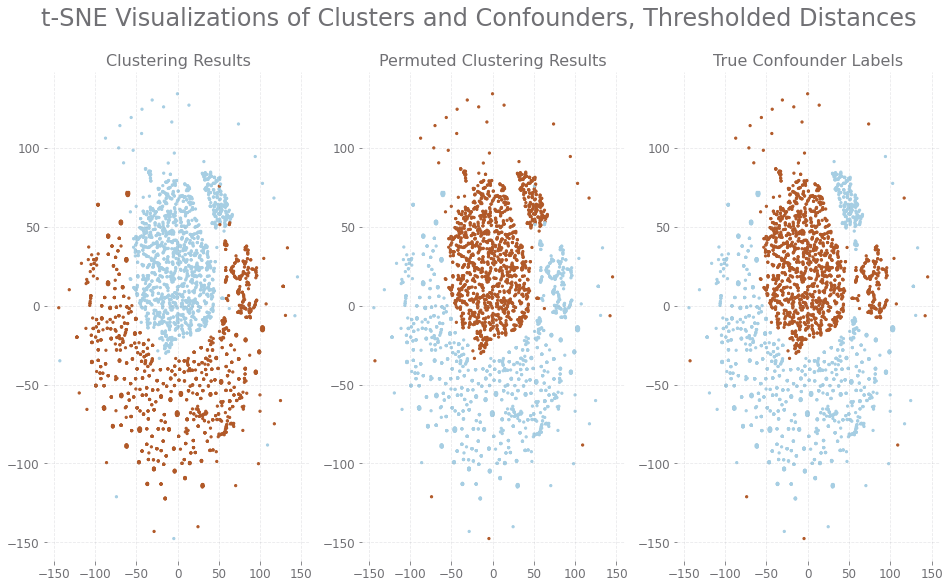

In [482]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsnebase[:,0], tsnebase[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsnebase[:,0], tsnebase[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsnebase[:,0], tsnebase[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

## MLE vs MAP

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances')

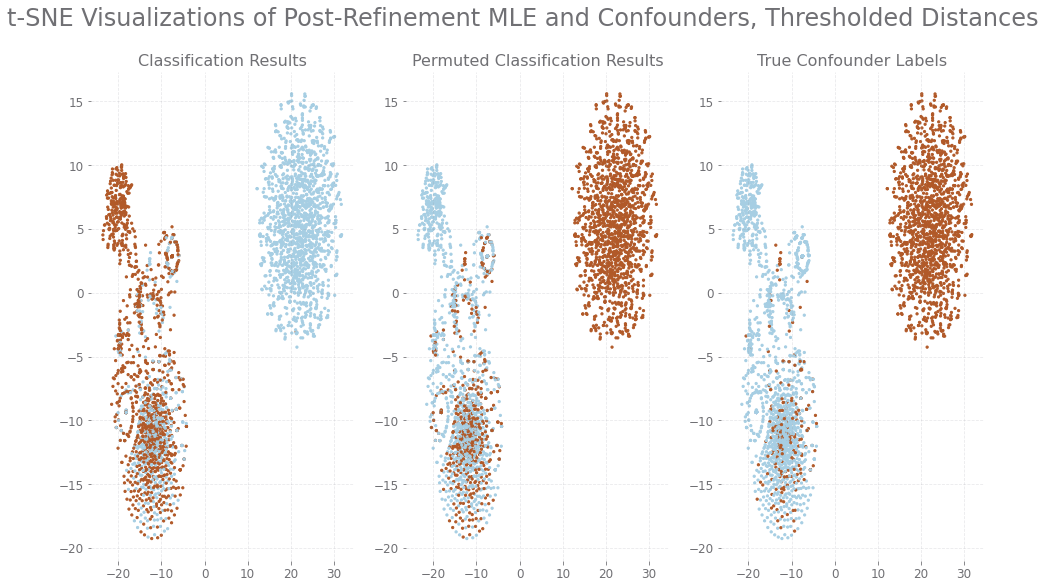

In [483]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemlelab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemlelab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances', fontsize=24)

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances')

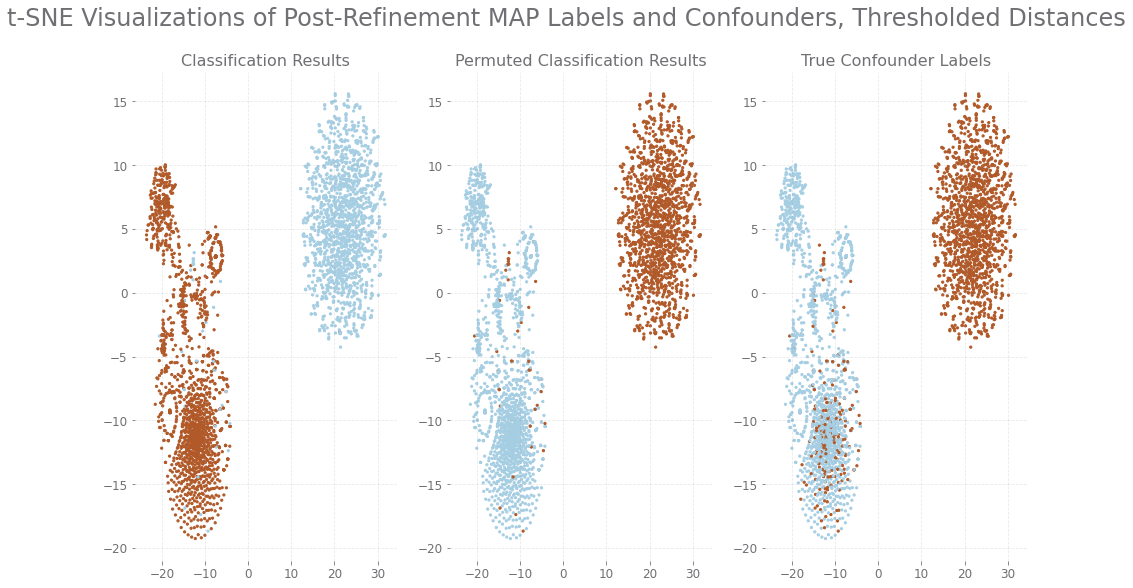

In [484]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemaplab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemaplab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances', fontsize=24)

array([[-2.32022769e+02, -2.24736081e+02,  8.51027813e-11, ...,
        -8.03057642e+01, -9.83282962e+01,  8.51027813e-11],
       [-1.05223841e+02, -9.19053000e+01,  8.51027813e-11, ...,
        -1.08292828e+02, -1.30896765e+02,  8.51027813e-11]])